In [2]:
import argparse
import os
import numpy as np
import torch
from tqdm import tqdm 
import glob
from utils import utils_transform
import pickle
from model.FLAME import FLAME
import cv2 
import face_alignment
import matplotlib.pyplot as plt
import collections
from utils.famos_camera import perspective_project, load_mpi_camera

In [3]:

def detect_lmk_on_img(img_path):

    image = cv2.imread(img_path)
    rgb_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 

    # face detection model
    face_detector_kwargs = {
        'back_model': False
    }
    fa = face_alignment.FaceAlignment(
        face_alignment.LandmarksType.THREE_D, 
        flip_input=False,
        face_detector='blazeface',    # support detectors ['dlib', 'blazeface', 'cfd]
        face_detector_kwargs = face_detector_kwargs,
        dtype=torch.bfloat16, device='cuda',
    )    

    # Facial landmarks
    lmks, lmk_score, bbox = fa.get_landmarks_from_image(rgb_img, return_bboxes=True, return_landmark_score=True) # tuple of (lmks, lmk_score, bbox)
    lmks_3d = lmks[0]
    return lmks_3d, lmk_score, rgb_img

def normalize_lmk_3d(lmk_3d):
    root_idx = 30
    pivot_idx = 27
    root_node = lmk_3d[root_idx]
    nose_len = np.linalg.norm(lmk_3d[pivot_idx]-root_node, 2, -1)
    
    lmk_3d_normed = (lmk_3d - root_node) / nose_len
    print(np.linalg.norm(lmk_3d_normed[pivot_idx]-lmk_3d_normed[root_idx], 2, -1))
    return lmk_3d_normed


def test(root_dir, subject, motion, frame_id, flame):
    dataset = 'FaMoS'
    flame_params_folder = os.path.join(root_dir, dataset, "flame_params")
    img_folder = os.path.join(root_dir, dataset, "downsampled_images_4")
    
    camera_name = "26_C" # name of the selected camera view
    flame_fname = os.path.join(flame_params_folder, subject, f"{motion}.npy")
    img_path = os.path.join(img_folder, subject, motion, frame_id, f'{motion}.{frame_id}.{camera_name}.png')
    flame_motion = np.load(flame_fname, allow_pickle=True)[()]
    
    idx = np.where(flame_motion["frame_id"] == int(frame_id))[0][0]
    print("idx = ", idx)
    
    shape = flame_motion["flame_shape"][idx]
    expression = flame_motion["flame_expr"][idx]
    rot_aa = flame_motion["flame_pose"][idx, :-2*3] # full pose exluding eye pose (global, neck, jaw) 3 * 3
    trans = flame_motion['flame_trans'][idx]
    
    # camera params
    camera_calibration_folder = os.path.join(root_dir, dataset, "calibrations")
    calib_fname = os.path.join(camera_calibration_folder, subject, motion, f"{camera_name}.tka")
    calibration = load_mpi_camera(calib_fname, resize_factor=4)
    camera_intrinsics = calibration["intrinsics"]
    camera_extrinsics = calibration["extrinsics"]
    radial_distortion = calibration["radial_distortion"]
    R_C, t_C = camera_extrinsics[:, :3], camera_extrinsics[:, 3]

    # flame mesh in the world coord
    verts_world, lmk_3d_world = flame(
        torch.Tensor(shape).reshape(1, -1), 
        torch.Tensor(expression).reshape(1, -1), 
        torch.Tensor(rot_aa).reshape(1, -1), 
        torch.Tensor(trans).reshape(1, -1))
    lmk_3d_world = lmk_3d_world[0].numpy()
    lmk_3d_cam = R_C.dot(lmk_3d_world.T).T + t_C
    lmk3d_cam_normed = normalize_lmk_3d(lmk_3d_cam)

    # lmk detection
    lmk3d_img, lmk_score, image = detect_lmk_on_img(img_path)
    lmk3d_img[:, 2] = -lmk3d_img[:, 2]  # invert z
    lmk3d_img_normed = normalize_lmk_3d(lmk3d_img)
    print(lmk_score)
    # print(lmk3d_cam_normed - lmk3d_img_normed)

    # visualize
    plot_style = dict(marker='o',
                  markersize=4,
                  linestyle='-',
                  lw=2)
    pred_type = collections.namedtuple('prediction_type', ['slice', 'color'])
    pred_types = {'face': pred_type(slice(0, 17), (0.682, 0.780, 0.909, 0.5)),
                'eyebrow1': pred_type(slice(17, 22), (1.0, 0.498, 0.055, 0.4)),
                'eyebrow2': pred_type(slice(22, 27), (1.0, 0.498, 0.055, 0.4)),
                'nose': pred_type(slice(27, 31), (0.345, 0.239, 0.443, 0.4)),
                'nostril': pred_type(slice(31, 36), (0.345, 0.239, 0.443, 0.4)),
                'eye1': pred_type(slice(36, 42), (0.596, 0.875, 0.541, 0.3)),
                'eye2': pred_type(slice(42, 48), (0.596, 0.875, 0.541, 0.3)),
                'lips': pred_type(slice(48, 60), (0.596, 0.875, 0.541, 0.3)),
                'teeth': pred_type(slice(60, 68), (0.596, 0.875, 0.541, 0.4))
                }
    fig = plt.figure(figsize=plt.figaspect(.5))
    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(image)
    for pred_type in pred_types.values():
        ax.plot(lmk3d_img[pred_type.slice, 0],
                lmk3d_img[pred_type.slice, 1],
                color=pred_type.color, **plot_style)

    ax.axis('off')

    ax = fig.add_subplot(1, 2, 2, projection='3d')
    surf = ax.scatter(lmk3d_cam_normed[:, 0],
                    lmk3d_cam_normed[:, 1],
                    lmk3d_cam_normed[:, 2],
                    c='cyan',
                    alpha=1.0,
                    edgecolor='b')

    for pred_type in pred_types.values():
        ax.plot3D(lmk3d_cam_normed[pred_type.slice, 0],
                lmk3d_cam_normed[pred_type.slice, 1],
                lmk3d_cam_normed[pred_type.slice, 2], color='blue')
    ax.view_init(elev=90., azim=45.)
    ax.set_xlim(ax.get_xlim()[::-1])

    # vis detected 3d lmk
    surf = ax.scatter(lmk3d_img_normed[:, 0],
                    lmk3d_img_normed[:, 1],
                    lmk3d_img_normed[:, 2],
                    c='red',
                    alpha=1.0,
                    edgecolor='r')

    for pred_type in pred_types.values():
        ax.plot3D(lmk3d_img_normed[pred_type.slice, 0],
                lmk3d_img_normed[pred_type.slice, 1],
                lmk3d_img_normed[pred_type.slice, 2], color='red')
    
    plt.show()

creating the FLAME Decoder
idx =  12
0.9999999999999999
1.0
[array([0.8671875 , 0.8046875 , 0.7890625 , 0.8046875 , 0.76953125,
       0.77734375, 0.76953125, 0.6875    , 0.6640625 , 0.6796875 ,
       0.73828125, 0.765625  , 0.796875  , 0.76171875, 0.76171875,
       0.78125   , 0.80078125, 0.84375   , 0.87890625, 0.85546875,
       0.859375  , 0.87890625, 0.84765625, 0.859375  , 0.8671875 ,
       0.88671875, 0.84375   , 0.859375  , 0.84375   , 0.83203125,
       0.8828125 , 0.88671875, 0.87890625, 0.890625  , 0.875     ,
       0.87109375, 0.89453125, 0.85546875, 0.890625  , 0.875     ,
       0.91015625, 0.89453125, 0.91015625, 0.91015625, 0.859375  ,
       0.83984375, 0.87109375, 0.87890625, 0.8203125 , 0.82421875,
       0.82421875, 0.8359375 , 0.8203125 , 0.87109375, 0.87109375,
       0.85546875, 0.83984375, 0.83984375, 0.8515625 , 0.8359375 ,
       0.84765625, 0.84375   , 0.87890625, 0.85546875, 0.890625  ,
       0.83984375, 0.84765625, 0.85546875], dtype=float32)]


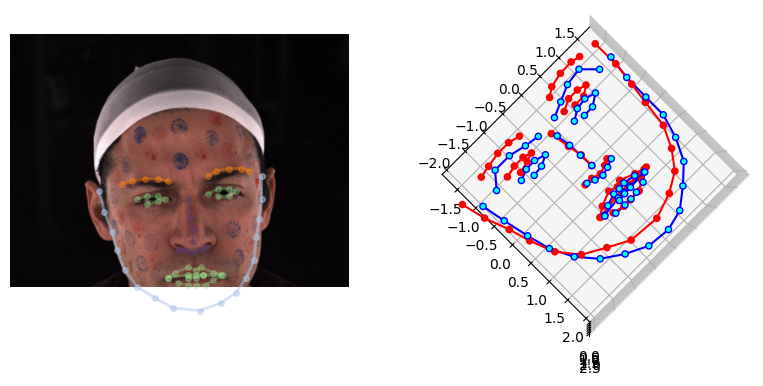

In [5]:
flame_model_path = 'flame_2020/generic_model.pkl'
flame_lmk_embedding_path = 'flame_2020/dense_lmk_embedding.npy'
root_dir = "./dataset"
flame = FLAME(flame_model_path, flame_lmk_embedding_path)
test(
    root_dir=root_dir, 
    subject="FaMoS_subject_001", 
    motion="anger", 
    frame_id="000013", 
    flame=flame)

In [7]:
subject

('FaMoS_subject_001',)

In [8]:
flame_model_path = 'flame_2020/generic_model.pkl'
flame_lmk_embedding_path = 'flame_2020/dense_lmk_embedding.npy'
root_dir = "./dataset"
flame = FLAME(flame_model_path, flame_lmk_embedding_path)
subject="FaMoS_subject_001"
motion="anger"
frame_id="000013"
dataset = 'FaMoS'
flame_params_folder = os.path.join(root_dir, dataset, "flame_params")
img_folder = os.path.join(root_dir, dataset, "downsampled_images_4")

camera_name = "26_C" # name of the selected camera view
flame_fname = os.path.join(flame_params_folder, subject, f"{motion}.npy")
img_path = os.path.join(img_folder, subject, motion, frame_id, f'{motion}.{frame_id}.{camera_name}.png')
flame_motion = np.load(flame_fname, allow_pickle=True)[()]

idx = np.where(flame_motion["frame_id"] == int(frame_id))[0][0]
print("idx = ", idx)

shape = flame_motion["flame_shape"][idx]
expression = flame_motion["flame_expr"][idx]
rot_aa = flame_motion["flame_pose"][idx, :-2*3] # full pose exluding eye pose (global, neck, jaw) 3 * 3
trans = flame_motion['flame_trans'][idx]

# camera params
camera_calibration_folder = os.path.join(root_dir, dataset, "calibrations")
calib_fname = os.path.join(camera_calibration_folder, subject, motion, f"{camera_name}.tka")
calibration = load_mpi_camera(calib_fname, resize_factor=4)
camera_intrinsics = calibration["intrinsics"]
camera_extrinsics = calibration["extrinsics"]
radial_distortion = calibration["radial_distortion"]
R_C, t_C = camera_extrinsics[:, :3], camera_extrinsics[:, 3]

# flame mesh in the world coord
verts_world, lmk_3d_world = flame(
    torch.Tensor(shape).reshape(1, -1), 
    torch.Tensor(expression).reshape(1, -1), 
    torch.Tensor(rot_aa).reshape(1, -1), 
    torch.Tensor(trans).reshape(1, -1))
lmk_3d_world = lmk_3d_world[0].numpy()
lmk_3d_cam = R_C.dot(lmk_3d_world.T).T + t_C
lmk3d_cam_normed = normalize_lmk_3d(lmk_3d_cam)

# lmk detection
lmk3d_img, lmk_score, image = detect_lmk_on_img(img_path)
lmk3d_img[:, 2] = -lmk3d_img[:, 2]  # invert z
lmk3d_img_normed = normalize_lmk_3d(lmk3d_img)
print(lmk_score)
# print(lmk3d_cam_normed - lmk3d_img_normed)

creating the FLAME Decoder
idx =  12
0.9999999999999999
1.0
[array([0.8671875 , 0.8046875 , 0.7890625 , 0.8046875 , 0.76953125,
       0.77734375, 0.76953125, 0.6875    , 0.6640625 , 0.6796875 ,
       0.73828125, 0.765625  , 0.796875  , 0.76171875, 0.76171875,
       0.78125   , 0.80078125, 0.84375   , 0.87890625, 0.85546875,
       0.859375  , 0.87890625, 0.84765625, 0.859375  , 0.8671875 ,
       0.88671875, 0.84375   , 0.859375  , 0.84375   , 0.83203125,
       0.8828125 , 0.88671875, 0.87890625, 0.890625  , 0.875     ,
       0.87109375, 0.89453125, 0.85546875, 0.890625  , 0.875     ,
       0.91015625, 0.89453125, 0.91015625, 0.91015625, 0.859375  ,
       0.83984375, 0.87109375, 0.87890625, 0.8203125 , 0.82421875,
       0.82421875, 0.8359375 , 0.8203125 , 0.87109375, 0.87109375,
       0.85546875, 0.83984375, 0.83984375, 0.8515625 , 0.8359375 ,
       0.84765625, 0.84375   , 0.87890625, 0.85546875, 0.890625  ,
       0.83984375, 0.84765625, 0.85546875], dtype=float32)]


In [14]:
print(camera_intrinsics.astype(int))

[[1206    0  178]
 [   0 1206  154]
 [   0    0    1]]


In [10]:
K = np.array([
    [1500.0, 0, 200.0],
    [0, 1500.0, 150.0],
    [0, 0, 1]
])

k_new = np.linalg.inv(K) @ camera_intrinsics
k_new

array([[ 0.80459708,  0.        , -0.01424034],
       [ 0.        ,  0.80459708,  0.0031816 ],
       [ 0.        ,  0.        ,  1.        ]])

In [19]:
print(camera_extrinsics)

[[ 9.98142994e-01 -1.79963786e-02 -5.81953107e-02  1.74233688e-02]
 [-2.53047178e-04 -9.56578931e-01  2.91473301e-01  6.46675456e-03]
 [-6.09138719e-02 -2.90917308e-01 -9.54807112e-01  9.80280157e-01]]


In [16]:
extrin_new = k_new @ camera_extrinsics
R1, T1 = extrin_new[:, :3], extrin_new[:, 3]

In [21]:
from scipy.spatial.transform  import Rotation

In [26]:
r_from_knew = np.asarray(Rotation.from_matrix(k_new).as_matrix())
print(r_from_knew.shape)
print(r_from_knew.T @ r_from_knew)
print(r_from_knew)

(3, 3)
[[1.00000000e+00 1.22783689e-21 3.94210396e-19]
 [1.22783689e-21 1.00000000e+00 5.62885456e-20]
 [3.94210396e-19 5.62885456e-20 1.00000000e+00]]
[[ 9.99968865e-01  6.95613904e-06 -7.89101515e-03]
 [ 6.95613904e-06  9.99998446e-01  1.76302420e-03]
 [ 7.89101515e-03 -1.76302420e-03  9.99967311e-01]]


In [28]:
np.divide(k_new, r_from_knew)

array([[ 0.80462213,  0.        ,  1.80462658],
       [ 0.        ,  0.80459833,  1.80462658],
       [ 0.        , -0.        ,  1.00003269]])

In [31]:
extrin_new_appox = r_from_knew @ camera_extrinsics

In [32]:
np.divide(extrin_new, extrin_new_appox)

array([[0.80510349, 0.65812563, 0.65592031, 0.00611855],
       [1.12421187, 0.80513413, 0.79879042, 1.01548094],
       [1.14855827, 1.00537031, 0.99901451, 0.99990407]])

In [41]:
# average focal_length computation
calib_dir = 'dataset/FaMoS/calibrations'
fx = []
cnt = 0
for sub in os.listdir(calib_dir):
    if not sub.startswith('FaMoS'):
        continue
    for motion in os.listdir(os.path.join(calib_dir, sub)):
        calib_fname = os.path.join(calib_dir, sub, motion, '26_C.tka')
        if not os.path.isfile(calib_fname):
            continue
        calibration = load_mpi_camera(calib_fname, resize_factor=4)
        fx.append(calibration['intrinsics'][0, 0])
fx = np.array(fx)
        